In [2]:
import tclab
import numpy
import pandas

import tbcontrol
from tbcontrol import blocksim

import matplotlib.pyplot as plt
from latex_figure import plotfigure

import datetime

# Parameter Functions

In [3]:
def cohen_coon(controller_type, parameters):
    K, tau, theta =  parameters
    
    if controller_type == 'P':
        Kc = (1.03/K)*(tau/theta + 0.34)
        return Kc

#PI controller
    if controller_type == 'PI':
        Kc = (0.9/K)*(tau/theta + 0.092)
        tauI = (3.33*theta)*((tau + 0.092*theta)/(tau + 2.22*theta))
        return Kc, tauI


#PD controller
    if controller_type == 'PD':
        Kc = (1.24/K)*(tau/theta + 0.129)
        taud = 0.27*theta*((tau - 0.324*theta)/(tau + 0.129*theta))
        α = 2
        return Kc, taud, α

#PID controller
    if controller_type == 'PID':
        Kc = (1.35/K)*(tau/theta + 0.185)
        tauI = 2.5*theta*((tau + 0.185*theta)/(tau + 0.611*theta))
        taud = 0.37*theta*(tau/(tau + 0.185*theta))
        return Kc, tauI, taud

In [4]:
def IAE_setpoints(controller_type, parameters):
    K, tau, theta = parameters
#setpoints
    if controller_type == 'PI':   
        # PI
        Kc = (0.758/K)*(theta/tau)**-0.861
        tauI = tau/(1.02 - 0.323*(theta/tau))
        return Kc, tauI


    if controller_type == 'PID':
        # PID
        Kc = (1.086/K)*(theta/tau)**-0.869
        tauI = tau/(0.740 - 0.130*(theta/tau))
        taud = 0.348*tau*(theta/tau)**0.914
        return Kc, tauI, taud

In [5]:
def IAE_disturbances(controller_type, parameters):
    K, tau , theta = parameters
#disturbance
    if controller_type == 'P':
        # P
        Kc = (0.902/K)*(theta/tau)**-0.985
        return Kc
    
    if controller_type == 'PI':
        # PI
        Kc = (0.984/K)*(theta/tau)**-0.986
        tauI = (tau/0.608)*(theta/tau)**0.707
        return Kc, tauI

    if controller_type == 'PID':
        # PID
        Kc = (1.435/K)*(theta/tau)**-0.921
        tauI = (tau/0.878)*(theta/tau)**0.749
        taud = 0.482*tau*(theta/tau)**1.137
        return Kc, tauI, taud

# Block Sim Creation

In [6]:
def controller_block(controller_type, parameters):
    
    if controller_type == 'P':
        Kc_P = parameters
        Gc_P = blocksim.LTI('Gc_P', 'e', 'Q', Kc_P, 1)
        return Gc_P
    
    if controller_type == 'PI':
        Kc_PI, tauI_PI = parameters
        Gc_PI = blocksim.PI('Gc_PI','e','Q', Kc_PI, tauI_PI)
        return Gc_PI
    
    if controller_type == 'PD':
        Kc_PD, tauD_PD, α = parameters
        Gc_PD = blocksim.LTI('Gc_PD','e','Q', [Kc_PD * tauD_PD * (α + 1), Kc_PD], [tauD_PD * α, 1]) 
        # Used the α term for physical realizability - Textbook eq 7-12 pg 129
        return Gc_PD
    
    if controller_type == 'PID':
        Kc_PID, tauI_PID, tauD_PID = parameters
        Gc_PID = blocksim.PID('Gc_PID', 'e', 'Q', Kc_PID, tauI_PID, tauD_PID)
        return Gc_PID

In [7]:
def system_block(parameters):
    K, tau, theta = parameters
    Gp = blocksim.LTI('Gp', 'Q', 'Tp', K, [tau, 1], theta) # Block of the system FOPDT model
    return Gp

# Params

In [24]:
K_50 = 0.6423177737615754
tau_50 = 150.3121523254063
theta_50 = 17.396993066317368

In [25]:
params_50 = [K_50, tau_50, theta_50]

In [26]:
integral_steps = 10

In [27]:
run_length = 2000

# Runs

In [37]:
Gp = system_block(params_50)

In [38]:
all_controller_blocks = []

all_controller_blocks.append(controller_block('PI', IAE_setpoints('PI', params_50)))
all_controller_blocks.append(controller_block('PI', IAE_setpoints('PI', params_50)))

In [39]:
all_controller_blocks# = [all_controller_blocks[0]]

[PI: e →[ Gc_PI ]→ Q, PI: e →[ Gc_PI ]→ Q]

In [62]:
noise = [0.01, 1]

In [81]:
sampling_rate = [1,50]

In [82]:
total_time = run_length*len(all_controller_blocks)

In [83]:
str(datetime.timedelta(seconds=total_time)), total_time

('1:06:40', 4000)

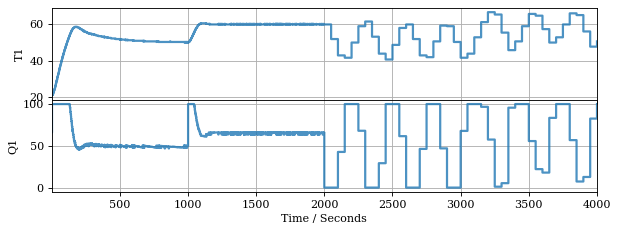

TCLab Model disconnected successfully.


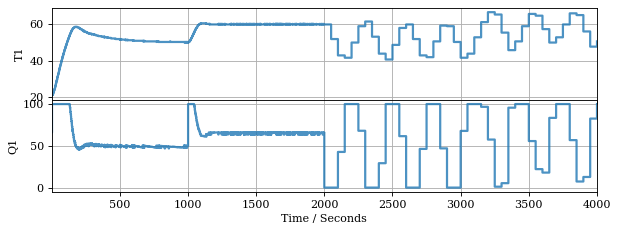

In [84]:
TCLab = tclab.setup(connected=False, speedup = 10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = tclab.Plotter(h, total_time)
    
    
    for index, Gc in enumerate(all_controller_blocks):
        n = noise[index]
        sample = sampling_rate[index]
        checker = 0
        for t in tclab.clock(run_length):         
            
            if t < run_length/2:
                T1sp = 50
            else:
                T1sp = 60
            
            if t/sample>=checker:
                Q1 = lab.Q1(float(Gc.output+50))
                T1 = lab.T1 + numpy.random.randn()*n
                e = T1sp-T1
                
                checker+=1
                print (T1, n, sample, t)

                for step in range(integral_steps):
                    Gc.change_input(t,e)
                    Gc.change_state(Gc.state+Gc.derivative(e)/integral_steps)

    #             h.update(t + index*run_length) 
                p.update(t + index*run_length)

In [85]:
h.get_sessions()

[(1, '2020-03-03 12:51:16', 1595)]

In [86]:
h.load_session(1)

In [87]:
data = {"Time" : h.t, "T1" : h.logdict['T1'], "Q1" : h.logdict['Q1']}

In [88]:
data_frame = pandas.DataFrame(data = data)
data_frame.to_csv("Combined Effects.csv")

data_frame.index = data_frame['Time']
data_frame = data_frame.drop(columns = 'Time')
data_frame

,T1,Q1
Time,,
0.00,20.6272,65.903460
3.00,20.9495,100.000000
4.00,20.9495,100.000000
5.00,20.9495,100.000000
6.00,20.9495,100.000000
...,...,...
3800.06,66.0715,56.839530
3850.07,65.1046,7.294489
3900.08,56.0802,12.726815


In [89]:
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
HALFSIZE = 3, 3 * aspect_ratio

In [90]:
y = [data_frame['T1'][1000:2000], data_frame['T1'][3000:4000]]
x = [data_frame['T1'][1000:2000].index, data_frame['T1'][3000:4000].index-2000]

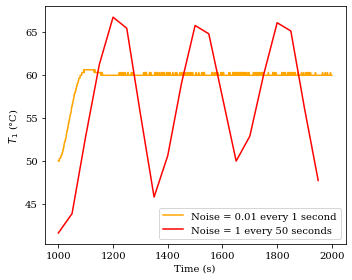

In [91]:
plotfigure(x, y, 
           ["Noise = {} every {} second".format(noise[0],sampling_rate[0]), "Noise = {} every {} seconds".format(noise[1],sampling_rate[1])], 
           ['orange', 'r'], 
           'Time (s)', '$T_1$ (\u00b0C)', 
           figsize = FULLSIZE, 
           filename = r'PDFS\\' + 'Sampling Rate and Noise.pdf',
            legend = True)
        